# RLMTP Basic Example

## Installation

If you have not already installed rlmtp, this can be done easily by cloning the git repository, then using pip.
First, open any command line tool and call
```
git clone https://c4science.ch/source/rlmtp.git
cd rlmtp
pip install .
```
if you are using the https protocol with git, or
```
git clone ssh://git@c4science.ch/source/rlmtp.git
cd rlmtp
pip install .
```
if you are using ssh with git.
See https://git-scm.com/ for details on git.

rlmtp contains tools to post-process material coupon test data. This notebook contains shows the basic usage of this package. The first step is to load the package.

In [1]:
import rlmtp

The rest of this example illustrates the functionality of rlmtp. First, let's load some other useful packages for this example.

In [2]:
from IPython.display import Image, IFrame
import matplotlib.pyplot as plt

## Sync stress-strain data with temperature data

Since we record the stress-strain and temperature through two different softwares, we would like to syncronize the measurements. This is done by matching the system times between the two sets of recordings --- rlmtp takes care of this step for you. First, we need to import the data from our different sources. Two functions are provided for this task, make sure that the data files follow the established format, otherwise the import will fail.

In [3]:
path_to_dion_data = '../rlmtp/tests/LP9_1_181211.xlsx'  # replace with your path
dion_data = rlmtp.import_dion7_data(path_to_dion_data)
path_to_catman_data = '../rlmtp/tests/Temp_LP9_1_181211.XLSX'  # replace with your path
catman_data = rlmtp.import_catman_data(path_to_catman_data)

Now we can simply syncronize the data, and add the temperature measurements to the stress-strain measurements. The syncrhonization is done based on the 'System Date' column that exists within dion_data.data and catman_data.data. A copy of the Dion7 data is returned with a column of 'Temperature[C]'.

In [4]:
synced_data = rlmtp.sync_temperature(dion_data, catman_data)

The measurement data is now accessed through synced_data. The returned data is a pandas.DataFrame object.

## Process databases stored in the specified format

A protocol is provided for the storage of coupon data, your life is made much easier if you follow this format. In this example the data is loaded automatically, the temperature is synchronized, the synchronized data is output, and plots are generated. In this example, the coupon data stored in the "test_specimen" directory follows our format.

In [5]:
coupon_dir = '../rlmtp/tests/test_specimen/'
output_dir = './'
processed_data = rlmtp.process_specimen_data(coupon_dir, output_dir)

Checking files...
	 Dion7 data exists.
	 catman data exists.
	 Filtering information exists.
Syncing temperature data with Dion7 data...
Filtering the data...


C:\Users\hartlope\AppData\Local\Continuum\Anaconda3\lib\site-packages\rlmtp\filtering.py:43: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x[i_current:i_next], y[i_current:i_next], poly_order)
C:\Users\hartlope\AppData\Local\Continuum\Anaconda3\lib\site-packages\rlmtp\filtering.py:43: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x[i_current:i_next], y[i_current:i_next], poly_order)


Data reduced from 18382 to 2847 data points.
Generating the output...
Finished processing!


The function let's you know what data it finds, if the data is not found then: 1) it does not exist, 2) it is not named properly, or 3) it is not in the correct location. The process_specimen_data() function is useful to easily process entire databases by creating a loop over all the directories that contain coupon data. The processed_data variable contains all the data collected by the function, we'll use it later.

The output from process_specimen_data() is generated in [output_dir]/[coupon_root], where coupon_root is the name of the directory that contains all the data for the coupon test. In this example the output is in "./test_specimen/", you can see: processed_data.csv, containing the test data; stress_strain_plot.pdf, the true stress - true strain plot; and temperature_time_plot.pdf, the temperature plotted versus time. Let's look at the temperature response:

In [6]:
IFrame("./test_specimen/temperature_time_plot.pdf", width=400, height=300)

From this plot we can see that the temperature rise is between 6 to 7 degrees Celcius for this specimen. Finally, let's plot the temperature versus true strain. For this, we'll need to use the data in processed_data.

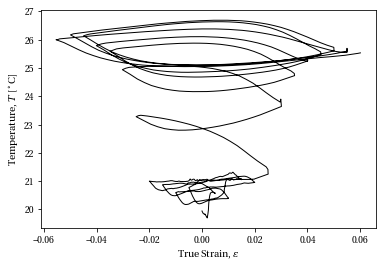

In [7]:
plt.figure()
plt.plot(processed_data['e_true'], processed_data['Temperature[C]'], c='k', lw=1.0)
plt.xlabel(r'True Strain, $\varepsilon$')
plt.ylabel(r'Temperature, $T$ [$^\circ$C]')
plt.show()

Now we can see that the temperature rise is mainly attributed to the cycles after 2 % strain, this is primarily because the strain rate increases at this point.

## Capture images at specified time steps

VERY IMPORTANT: This functionality requires that ffmpeg is installed (equivalently, ffmpeg and ffprobe are on the Path) on your system. ffmpeg is a free software, the pre-compiled binaries are available at: https://www.ffmpeg.org/download.html.

We may be interested to correlate the deformed shape of a specimen with particular time increments, for example to see if buckling has occured. For this example we need to load a new data set, and make sure we have the path to the video file of interest.

In [8]:
path_to_dion_data_2 = '../rlmtp/tests/testData_07012018.xlsx'
dion_data_2 = rlmtp.import_dion7_data(path_to_dion_data_2)
video = '../rlmtp/tests/D5600_B_254_132139_589.MOV'  # this file may not exist for you since it's around 1Gb we don't include it

For the following commands to work, rlmtp requires that the video starts before the Dion7 recordings, and ends after the Dion7 recordings. Therefore, take care when you are starting and stopping the video. In this example, we are interested in seeing if buckling has occured at the excursion to -5.5 % strain. We identified this as the 18059'th time increment. First, we get the time in the Dion7 data corresponding to this increment, then find how many seconds into the video this time occurs.

In [9]:
time_55_strain = dion_data_2.get_times_at_increments([18059])
video_time = rlmtp.dion7_times_to_video_times(video, time_55_strain)

In the above command, multiple increments can be added to the list (in ascending order) to get multiple times, however we just wanted one picture. Now we use the time from Dion7 to capture the frames from the video. The pictures are saved in jpeg format to output_dir, with the format [file\_name]\_[S]\_[ms].jpg, where S is the seconds in the video, and ms are the milliseconds.

In [10]:
output_dir = './'
file_name = 'ex_1_pic'
rlmtp.output_frames_at_times(video, video_time, output_dir, file_name)

C:\Users\hartlope\AppData\Local\Continuum\Anaconda3\lib\site-packages\rlmtp\sync_video.py:111: UserWarning: ./ex_1_pic_916_394.jpg already exists, no new file created!
  warnings.warn(out_path + ' already exists, no new file created!')


Now you can load the image and see the results.

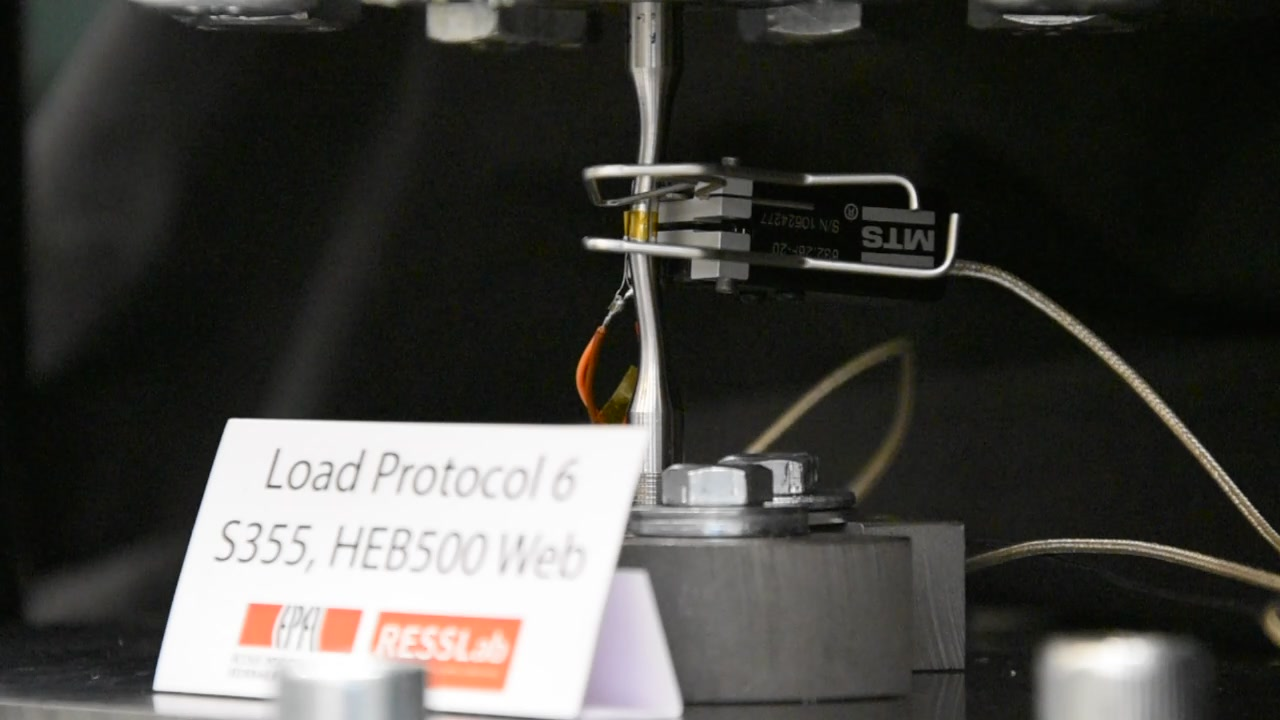

In [11]:
Image("./ex_1_pic_916_394.jpg")

Clearly buckling has occured at this stage!

## Database generation

If the protocols for specimen and database management are followed, a summary of all the tests can be generated automatically.
This is done through the write_description_database_csv function.
The function automatically walks through the database collecting all the specimen description information, then compiling it into a single file.

In [12]:
database_dir = '../rlmtp/tests/test_database/'
csv_output = './example_database.csv'
rlmtp.write_description_database_csv(database_dir, csv_output)

Found ../rlmtp/tests/test_database/campaign_1\LP1\Specimen 1\specimen_description.csv, adding to database...
Found ../rlmtp/tests/test_database/campaign_2\LP1\Specimen 1\specimen_description.csv, adding to database...
